In [1]:
import gymnasium as gym
import numpy as np
from itertools import count
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp
from tqdm import tqdm
import os
os.chdir('..')

# Deep deterministic policy gradient (DDPG)

[Deterministic policy gradient paper](https://proceedings.mlr.press/v32/silver14.pdf)

[Deep deterministic policy gradient paper](https://arxiv.org/pdf/1509.02971.pdf)

[Implementation here](../scripts/ddpg.py)

- **Only applicable to *continuous* action spaces**
- In continuous action spaces, greedy policy improvement using $\underset{a'}{\mathrm{argmax}}\;Q(s',a'; \theta)$, becomes very problematic as it requires a global maximisation at every step
- Alternatively, we can use a deterministic policy function to approximate the best action and move the policy in the direction of the gradient of $Q$:
  - The critic, $Q(s,a;\theta^Q)$ is learned using the Bellman equation like in Q-learning/DQN
  - The actor, $\mu(s;\theta^\mu)$ is updated by applying the chain rule to the gradient of $Q$ (w.r.t. $\theta^\mu$). This is derived from the *Deterministic Policy Gradient Theorem*, [proven by Silver et al.](https://proceedings.mlr.press/v32/silver14.pdf):
    - $$\nabla_{\theta^\mu}\approx \mathbb{E}_{s\sim \rho^\beta}\left[\nabla_{\theta^\mu} Q(s,\mu(s;\theta^\mu);\theta^Q)\right]$$
    - $$=\mathbb{E}_{s\sim \rho^\beta}\left[\nabla_{a}Q(s,a|\theta^Q) \nabla_{\theta^\mu}\mu(s;\theta^\mu)\right]$$
- DDPG uses many of the same stabilizing techniques as in DQN
  - Experience replay
  - Target networks (for both actor and critic)
- DDPG typically learns off-policy, with an exploration policy $u'$ that adds noise sampled from a noise process $\cal{N}$
  - $$\mu'(s_t)=\mu(s_t|\theta_t^\mu) + \cal{N}$$

![ddpg](ddpg.png)

# Twin Delayed DDPG (TD3)

[TD3 paper](https://arxiv.org/pdf/1802.09477.pdf)

The Q function in DDPG can tend to overestimate Q-values. Over time, these overestimations can develop into significant bias and lead to poor policy updates, creating a feedback loop where suboptimal actions may be highly valued by the suboptimal critic, further reinforcing said suboptimal action in the next policy update. **Twin Delayed DDPG** (TD3) introduces three key improvements to the original DDPG algorithm that address the overestimation problem and drastically improve performance.

1) ***Clipped Double Q-Learning***
   - In TD3, two critics, $Q_{\theta_1}$ and $Q_{\theta_2}$ are used to estimate the value function. In practical implementations, only one actor, $\pi_\phi$, is used and optimized with respect to $Q_{\theta_1}$.
   - $Q_{\theta_1}$ and $Q_{\theta_2}$ are updated with the following clipped target ($\theta'_i$ and $\phi'$ denotes target network parameters):
     - $$y=r+\gamma \underset{i\in\{1,2\}}\min Q_{\theta'_i}(s', \pi_{\phi'}(s'))$$
   - If $Q_{\theta_2}>Q_{\theta_1}$, then the update is the same as in original DDPG. If $Q_{\theta_2}<Q_{\theta_1}$, then the value is reduced to address potential overestimation.
   - While this technique induces underestimation bias, this is vastly preferable to overestimation as the value of underestimated actions is not explicitly propogated through the policy update.
2) ***Target Networks and Delayed Policy Updates***
   - In traditional DQN, target networks stablize the training progress and reduce the growth of error over multiple updates. [Fujimoto et al](https://arxiv.org/pdf/1802.09477.pdf) suggest updating the target networks and policy network at a lower frequency than the online value network (once every $d$ updates), to allow the value error to be sufficiently minimized before the target network and policy update. This improvement leads to lower variance on policy updates which decreases the likelihood of divergence. The implementation described in the original paper used a $d$ of $2$.
3) ***Target Policy Smoothing Regularization***
   - Another concern with deterministic policies is that they can overfit to narrow peaks in the value estimate. In many environments, similar actions should have similar value, which is reflected by a smooth value function. Fitting the value of a small area around the target action $$y=r+\mathbb{E}_\epsilon\left[Q_{\theta'}(s', \pi_{\phi'}(s')+\epsilon)\right]$$ helps smooth out the value estimate by bootstrapping off of similar state-action value estimates, forcing the network to generalize over similar actions.
   - In implementation, clipped noise defined by noice process $\cal{N}$ is added to the target policy $$\epsilon\sim \text{clip}(\cal{N}(0,\sigma), -c, c)$$ at each value network update.

![td3](td3.png)

# Demos

In [2]:
def run_deterministic_policy_model(env, policy_model, gamma=1.0, num_episodes=1, seed=None):
    ep_returns = []
    for _ in range(num_episodes):
        ep_return = 0
        state = env.reset(seed=seed)[0]
        for t in count():
            action = policy_model.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            ep_return += reward * gamma**t
            state = next_state
            if terminated or truncated:
                ep_returns.append(ep_return)
                break
    return ep_returns

## DDPG

### Pendulum

In [3]:
import pickle
from scripts.ddpg import FCDP, FCQV
res = {}
with open('testfiles/ddpg_pendulum.results', 'rb') as file:
    res = pickle.load(file)

Text(0.5, 1.0, 'Total return')

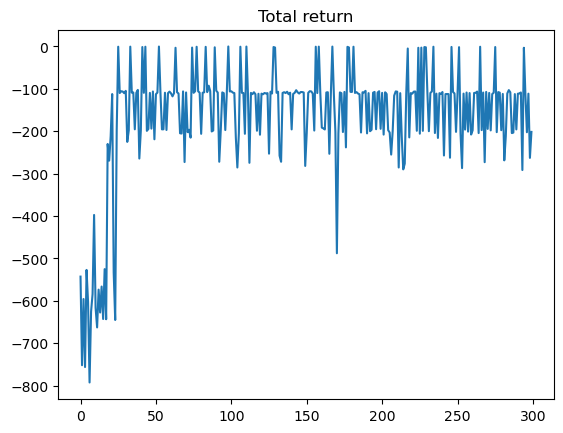

In [20]:
episode_returns = res['episode_returns']
plt.plot(range(len(episode_returns)), episode_returns)
plt.title('Total return')

Text(0.5, 1.0, 'Moving average of total return (k=100)')

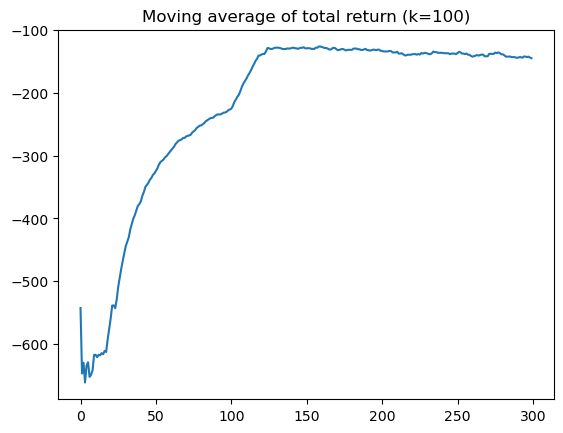

In [21]:
episode_returns = res['episode_returns']
plt.plot(range(len(episode_returns)), [np.mean(episode_returns[max(0,x-100):x+1]) for x in range(len(episode_returns))])
plt.title('Moving average of total return (k=100)')

In [4]:
env = gym.make("Pendulum-v1", render_mode='human')
run_deterministic_policy_model(env, res['best_model'], seed=42)
env.close()

In [5]:
import pygame
env = gym.make("Pendulum-v1", render_mode='human')
for k, v in res['saved_models'].items():
    print(f'Model at episode {k}')
    pygame.display.set_caption(f'Model at episode {k}')
    run_deterministic_policy_model(env, v, seed=42)
env.close()

Model at episode 1
Model at episode 10
Model at episode 50
Model at episode 100
Model at episode 250


### Lunar Lander

In [58]:
import pickle
from scripts.ddpg import FCDP, FCQV
res = {}
with open('testfiles/ddpg_lunarlander_limit.results', 'rb') as file:
    res = pickle.load(file)

Text(0.5, 1.0, 'Total return')

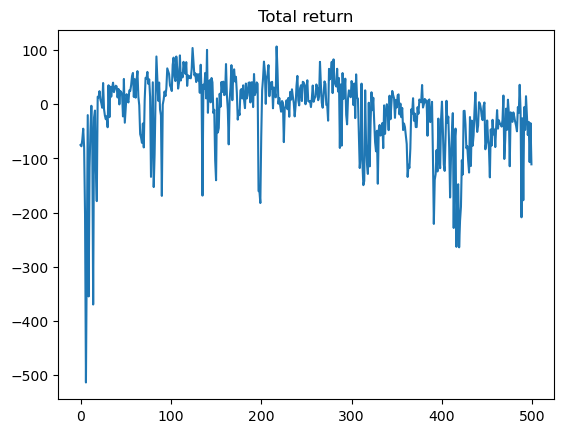

In [59]:
episode_returns = res['episode_returns']
plt.plot(range(len(episode_returns)), episode_returns)
plt.title('Total return')

Text(0.5, 1.0, 'Moving average of total return (k=100)')

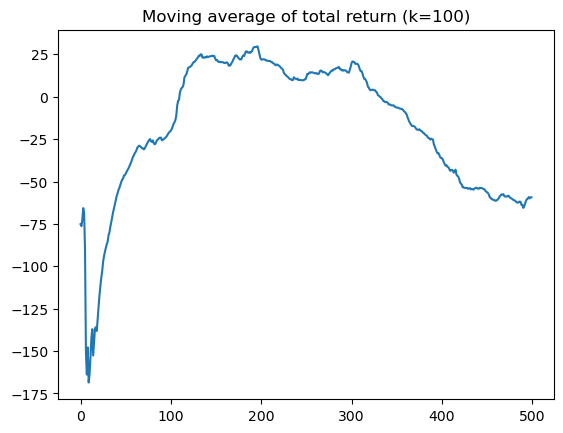

In [60]:
episode_returns = res['episode_returns']
plt.plot(range(len(episode_returns)), [np.mean(episode_returns[max(0,x-100):x+1]) for x in range(len(episode_returns))])
plt.title('Moving average of total return (k=100)')

In [61]:
env = gym.make("LunarLander-v2", continuous=True, render_mode='human')
run_deterministic_policy_model(env, res['best_model'])
env.close()

In [62]:
import pygame
env = gym.make("LunarLander-v2", continuous=True, render_mode='human')
for k, v in res['saved_models'].items():
    print(f'Model at episode {k}')
    pygame.display.set_caption(f'Model at episode {k}')
    run_deterministic_policy_model(env, v, seed=42)
env.close()

Model at episode 1
Model at episode 10
Model at episode 50
Model at episode 100
Model at episode 250
Model at episode 500


## TD3

### Pendulum

In [3]:
import pickle
from scripts.td3 import FCDP, FCTQV
res = {}
with open('testfiles/td3_pendulum.results', 'rb') as file:
    res = pickle.load(file)

Text(0.5, 1.0, 'Total return')

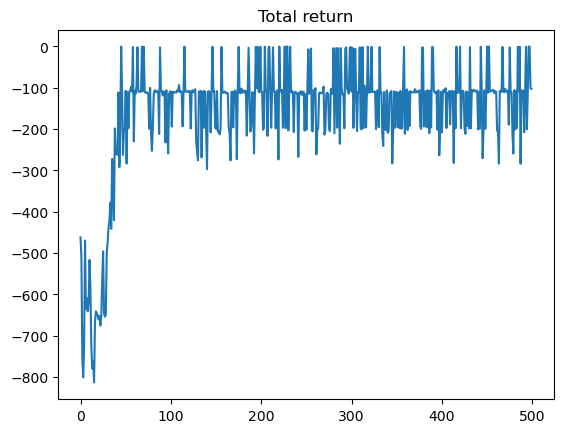

In [4]:
episode_returns = res['episode_returns']
plt.plot(range(len(episode_returns)), episode_returns)
plt.title('Total return')

Text(0.5, 1.0, 'Moving average of total return (k=100)')

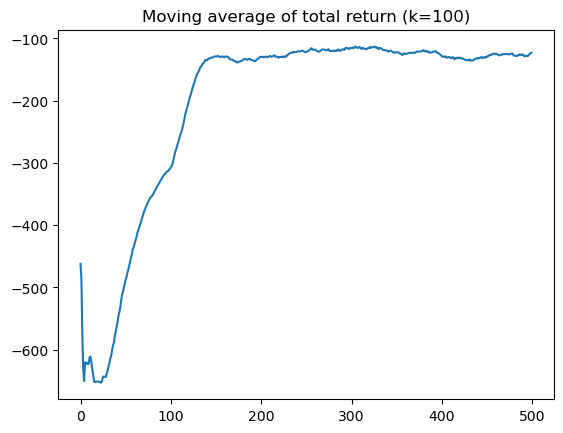

In [5]:
episode_returns = res['episode_returns']
plt.plot(range(len(episode_returns)), [np.mean(episode_returns[max(0,x-100):x+1]) for x in range(len(episode_returns))])
plt.title('Moving average of total return (k=100)')

In [6]:
env = gym.make("Pendulum-v1", render_mode='human')
run_deterministic_policy_model(env, res['best_model'], seed=42)
env.close()

In [7]:
import pygame
env = gym.make("Pendulum-v1", render_mode='human')
for k, v in res['saved_models'].items():
    print(f'Model at episode {k}')
    pygame.display.set_caption(f'Model at episode {k}')
    run_deterministic_policy_model(env, v, seed=42)
env.close()

Model at episode 1
Model at episode 10
Model at episode 50
Model at episode 100
Model at episode 250
Model at episode 500


### Lunar Lander

In [3]:
import pickle
from scripts.td3 import FCDP, FCTQV
res = {}
with open('testfiles/td3_lunarlander_limit.results', 'rb') as file:
    res = pickle.load(file)

Text(0.5, 1.0, 'Total return')

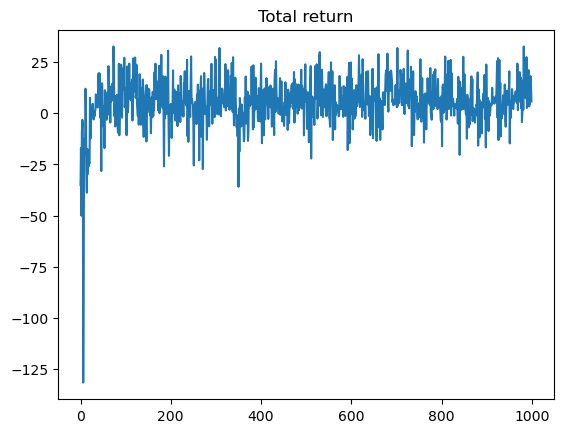

In [4]:
episode_returns = res['episode_returns']
plt.plot(range(len(episode_returns)), episode_returns)
plt.title('Total return')

Text(0.5, 1.0, 'Moving average of total return (k=100)')

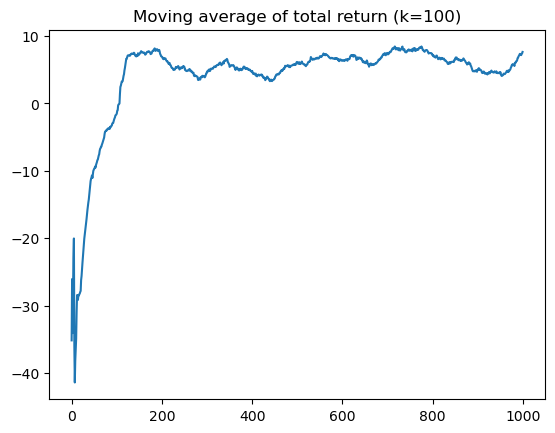

In [5]:
episode_returns = res['episode_returns']
plt.plot(range(len(episode_returns)), [np.mean(episode_returns[max(0,x-100):x+1]) for x in range(len(episode_returns))])
plt.title('Moving average of total return (k=100)')

In [6]:
env = gym.make("LunarLander-v2", continuous=True, render_mode='human')
run_deterministic_policy_model(env, res['best_model'])
env.close()

In [7]:
import pygame
env = gym.make("LunarLander-v2", continuous=True, render_mode='human')
for k, v in res['saved_models'].items():
    print(f'Model at episode {k}')
    pygame.display.set_caption(f'Model at episode {k}')
    run_deterministic_policy_model(env, v, seed=42)
env.close()

Model at episode 1
Model at episode 10
Model at episode 50
Model at episode 100
Model at episode 250
Model at episode 500
